![](img/330-banner.png)

# Lecture 21: Survival analysis 

UBC 2022-23

Instructor: Varada Kolhatkar

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

plt.rcParams["font.size"] = 12

# does lifelines try to mess with this?
pd.options.display.max_rows = 10

In [2]:
import lifelines

## Announcements

- HW8 released, due November 29th 11:59pm. 
- Only one more homework left, which is going to be on communication, where you'll be writing a blog post. 
- Next lecture on Ethics is going to be a guest lecture by [Giulia Toti]( https://www.gtoti.com/), who is currently teaching [Computer and Society](https://www.cs.ubc.ca/course-section/cpsc-430-102-2022w) course and who has taught CPSC 330 before. 

## Learning objectives

- Explain what is right-censored data. 
- Explain the problem with treating right-censored data the same as "regular" data.
- Determine whether survival analysis is an appropriate tool for a given problem.
- Apply survival analysis in Python using the `lifelines` package.
- Interpret a survival curve, such as the Kaplan-Meier curve.
- Interpret the coefficients of a fitted Cox proportional hazards model.
- Make predictions for existing individuals and interpret these predictions.

## Customer churn: our standard approach

- Imagine that you are working for a subscription-based telecom company. 
- You want to come up with retention strategies for different customer segments. 
- So you want to model the "time to churn" to understand different factors affecting customer churn.   
- Suppose you are given this dataset [Customer Churn Dataset](https://www.kaggle.com/blastchar/telco-customer-churn), which is collected at a fixed time. 

In [3]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
train_df, test_df = train_test_split(df, random_state=123)
train_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6464,4726-DLWQN,Male,1,No,No,50,Yes,Yes,DSL,Yes,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),70.35,3454.6,No
5707,4537-DKTAL,Female,0,No,No,2,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,45.55,84.4,No
3442,0468-YRPXN,Male,0,No,No,29,Yes,No,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),98.80,2807.1,No
3932,1304-NECVQ,Female,1,No,No,2,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55,Yes
6124,7153-CHRBV,Female,0,Yes,Yes,57,Yes,No,DSL,Yes,...,Yes,Yes,No,No,One year,Yes,Mailed check,59.30,3274.35,No


- We are interested in predicting customer churn: the "Churn" column.  
- How will you approach this problem with the approaches we have seen so far? 
- How about treating this as a binary classification problem where we want to predict `Churn` (yes/no) from these -other columns.
- Before we look into survival analysis, let's just treat it as a binary classification model where we want to predict whether a customer churned or not. 

In [4]:
train_df.shape

(5282, 21)

In [5]:
train_df["Churn"].value_counts()

No     3912
Yes    1370
Name: Churn, dtype: int64

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6464 to 3582
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5282 non-null   object 
 1   gender            5282 non-null   object 
 2   SeniorCitizen     5282 non-null   int64  
 3   Partner           5282 non-null   object 
 4   Dependents        5282 non-null   object 
 5   tenure            5282 non-null   int64  
 6   PhoneService      5282 non-null   object 
 7   MultipleLines     5282 non-null   object 
 8   InternetService   5282 non-null   object 
 9   OnlineSecurity    5282 non-null   object 
 10  OnlineBackup      5282 non-null   object 
 11  DeviceProtection  5282 non-null   object 
 12  TechSupport       5282 non-null   object 
 13  StreamingTV       5282 non-null   object 
 14  StreamingMovies   5282 non-null   object 
 15  Contract          5282 non-null   object 
 16  PaperlessBilling  5282 non-null   objec

Question: Does this mean there is no missing data?

Ok, let's try our usual approach:

In [7]:
train_df["SeniorCitizen"].value_counts()

0    4430
1     852
Name: SeniorCitizen, dtype: int64

In [8]:
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
drop_features = ["customerID"]
passthrough_features = ["SeniorCitizen"]
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [95]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

In [96]:
preprocessor.fit(train_df);

Hmmm, one of the numeric features is causing problems?

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Oh, looks like `TotalCharges` is not a numeric type. What if we change the type of this column to float? 

In [98]:
train_df["TotalCharges"] = train_df["TotalCharges"].astype(float)

Argh!!

In [100]:
for val in train_df["TotalCharges"]:
    try:
        float(val)
    except ValueError:
        print(val)

Any ideas?

Well, it turns out we can't see those problematic values because they are whitespace!

In [101]:
for val in train_df["TotalCharges"]:
    try:
        float(val)
    except ValueError:
        print('"%s"' % val)

Let's replace the whitespaces with NaNs. 

In [102]:
train_df = train_df.assign(
    TotalCharges=train_df["TotalCharges"].replace(" ", np.nan).astype(float)
)
test_df = test_df.assign(
    TotalCharges=test_df["TotalCharges"].replace(" ", np.nan).astype(float)
)

In [103]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6464 to 3582
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5282 non-null   object 
 1   gender            5282 non-null   object 
 2   SeniorCitizen     5282 non-null   int64  
 3   Partner           5282 non-null   object 
 4   Dependents        5282 non-null   object 
 5   tenure            5282 non-null   int64  
 6   PhoneService      5282 non-null   object 
 7   MultipleLines     5282 non-null   object 
 8   InternetService   5282 non-null   object 
 9   OnlineSecurity    5282 non-null   object 
 10  OnlineBackup      5282 non-null   object 
 11  DeviceProtection  5282 non-null   object 
 12  TechSupport       5282 non-null   object 
 13  StreamingTV       5282 non-null   object 
 14  StreamingMovies   5282 non-null   object 
 15  Contract          5282 non-null   object 
 16  PaperlessBilling  5282 non-null   objec

But now we are going to have missing values and we need to include imputation for numeric features in our preprocessor. 

In [104]:
preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features,
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

Now let's try that again...

In [105]:
preprocessor.fit(train_df);

It worked! Let's get the column names of the transformed data from the column transformer.

In [106]:
new_columns = (
    numeric_features
    + preprocessor.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + passthrough_features
)

In [107]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns=new_columns
)
X_test_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns=new_columns
)

In [108]:
X_train_enc.head()

,MonthlyCharges,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,Partner_No,Partner_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,StreamingTV_No,...,DeviceProtection_No internet service,DeviceProtection_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,SeniorCitizen
6464,0.185175,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5707,-0.641538,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3442,1.133562,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3932,0.458524,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
6124,-0.183179,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [109]:
results = {}

In [110]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [111]:
X_train = train_df.drop(columns=["Churn"])
X_test = test_df.drop(columns=["Churn"])

y_train = train_df["Churn"]
y_test = test_df["Churn"]

### DummyClassifier

In [112]:
dc = DummyClassifier()

In [113]:
results["dummy"] = mean_std_cross_val_scores(
    dc, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.000),0.001 (+/- 0.000),0.741 (+/- 0.000),0.741 (+/- 0.000)


Dummy model scores are pretty good because we have class imbalance. 

In [114]:
y_train.value_counts()

No     3912
Yes    1370
Name: Churn, dtype: int64

### LogisticRegression

In [115]:
lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [116]:
results["logistic regression"] = mean_std_cross_val_scores(
    lr, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.000),0.001 (+/- 0.000),0.741 (+/- 0.000),0.741 (+/- 0.000)
logistic regression,0.118 (+/- 0.031),0.008 (+/- 0.005),0.789 (+/- 0.011),0.792 (+/- 0.003)


In [117]:
confusion_matrix(y_train, cross_val_predict(lr, X_train, y_train))

array([[3481,  431],
       [ 683,  687]])

- Logistic regression beats the dummy model. 
- But it seems like we have many false negatives. 

### RandomForestClassifier

Let's try random forest model. 

In [118]:
rf = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=100))

In [119]:
results["random forest"] = mean_std_cross_val_scores(
    rf, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.000),0.001 (+/- 0.000),0.741 (+/- 0.000),0.741 (+/- 0.000)
logistic regression,0.118 (+/- 0.031),0.008 (+/- 0.005),0.789 (+/- 0.011),0.792 (+/- 0.003)
random forest,0.260 (+/- 0.013),0.020 (+/- 0.001),0.750 (+/- 0.008),0.993 (+/- 0.001)


In [120]:
confusion_matrix(y_train, cross_val_predict(rf, X_train, y_train))

array([[3411,  501],
       [ 825,  545]])

- Random forest is not improving the scores. 

- We might decide to do hyperparamter optimization to further improve the score. 
- But after trying out all the usual things should we be happy with the scores?
- Are we doing anything fundamentally wrong when we treat this problem as a binary classification? 
<br><br><br><br><br><br><br>

The rest of the class is about what is wrong with what we just did!

## Censoring and survival analysis

### Time to event and censoring

- When we treat the problem as a binary classification problem, we predict whether a customer would churn or not at a particular point in time, when the data was collected. 
- If a customer has not churned yet, wouldn't it be more useful to understand when they are likely to churn so that we can offer them promotions etc?  
- Here we are actually interested in the time till the event of churn occurs.  

There are many situations where you want to analyze **the time until an event occurs**. For example,

- the time until a customer leaves a subscription service (this dataset)
- the time until a disease kills its host
- the time until a piece of equipment breaks
- the time that someone unemployed will take to land a new job
- the time until you wait for your turn to get a surgery

Although this branch of statistics is usually referred to as **Survival Analysis**, the event in question does not need to be related to actual "survival". The important thing is to understand that we are interested in **the time until something happens**, or whether or not something will happen in a certain time frame.

In our dataset there is a column called "tenure", which encodes this temporal aspect of the data.  

In [121]:
train_df[["tenure"]].head()

,tenure
6464,50
5707,2
3442,29
3932,2
6124,57


- The tenure column is the number of months the customer has stayed with the company. 
- But we only have information about this till the point we collected the data. 

**Question:** But why is this different? Can't you just use the techniques you learned so far (e.g., regression models) to predict the time (tenure in our case)? Take a minute to think about this.
What could be possible scenarios for the duration column? 


<br><br><br><br><br><br>

The answer would be yes if you could observe the actual time in all occurrences, but you usually cannot. Frequently, there will be some kind of **censoring** which will not allow you to observe the exact time that the event happened for all units/individuals that are being studied.

In [122]:
train_df[["tenure", "Churn"]].head()

,tenure,Churn
6464,50,No
5707,2,No
3442,29,No
3932,2,Yes
6124,57,No


- What this means is that we **don't have correct target values** to train or test our model.
- This is a problem!

Let's consider some approaches to deal with this censoring issue.

### Approach 1: Only consider the examples where "Churn"=Yes

Let's just consider the cases _for which we have the time_, to obtain the average subscription length.

In [123]:
train_df_churn = train_df.query(
    "Churn == 'Yes'"
)  # Consider only examples where the customers churned.
test_df_churn = test_df.query(
    "Churn == 'Yes'"
)  # Consider only examples where the customers churned.
train_df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3932,1304-NECVQ,Female,1,No,No,2,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55,Yes
301,8098-LLAZX,Female,1,No,No,4,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.45,396.10,Yes
5540,3803-KMQFW,Female,0,Yes,Yes,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.55,20.55,Yes
4084,2777-PHDEI,Female,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,No,Electronic check,78.05,78.05,Yes
3272,6772-KSATR,Male,0,No,No,1,Yes,Yes,Fiber optic,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,81.70,81.70,Yes


In [124]:
train_df.shape

(5282, 21)

In [125]:
train_df_churn.shape

(1370, 21)

In [126]:
numeric_features

['MonthlyCharges']

In [127]:
preprocessing_notenure = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features[1:],  # Getting rid of the tenure column
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
)

In [128]:
tenure_lm = make_pipeline(preprocessing_notenure, Ridge())

tenure_lm.fit(train_df_churn.drop(columns=["tenure"]), train_df_churn["tenure"]);

In [129]:
pd.DataFrame(
    tenure_lm.predict(test_df_churn.drop(columns=["tenure"]))[:10],
    columns=["tenure_predictions"],
)

,tenure_predictions
0,7.279394
1,6.215408
2,13.277208
3,0.773501
4,56.752196
5,-4.499641
6,43.392362
7,7.629493
8,17.456213
9,10.649393


What will be wrong with our estimated survival times? Will they be too low or too high? 
<br><br><br><br><br><br><br>

On average they will be **underestimates** (too small), because we are ignoring the currently subscribed (un-churned) customers. Our dataset is a biased sample of those who churned within the time window of the data collection. Long-time subscribers were more likely to be removed from the dataset! This is a common mistake - see the [Calling Bullshit video](https://www.youtube.com/watch?v=ITWQ5psx9Sw) from the README!

<br><br>

### Approach 2: Assume everyone churns right now

Assume everyone churns right now - in other words, use the original dataset. 

In [130]:
train_df[["tenure", "Churn"]].head()

,tenure,Churn
6464,50,No
5707,2,No
3442,29,No
3932,2,Yes
6124,57,No


In [131]:
tenure_lm.fit(train_df.drop(columns=["tenure"]), train_df["tenure"]);

In [132]:
pd.DataFrame(
    tenure_lm.predict(test_df_churn.drop(columns=["tenure"]))[:10],
    columns=["tenure_predictions"],
)

,tenure_predictions
0,12.584305
1,10.500719
2,16.531451
3,5.134353
4,58.369512
5,0.217658
6,43.946802
7,13.994934
8,25.357242
9,14.412561


What will be wrong with our estimated survival time?
<br><br><br><br><br><br>

In [133]:
train_df[["tenure", "Churn"]].head()

,tenure,Churn
6464,50,No
5707,2,No
3442,29,No
3932,2,Yes
6124,57,No


It will be an **underestimate** again. For those still subscribed, while we did not remove them, we recorded a total tenure shorter than in reality, because they will keep going for some amount of time. 

<br><br>

### Approach 3: Survival analysis

Deal with this properly using [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis).

- You may learn about this in a statistics course.
- We will use the `lifelines` package in Python and will not go into the math/stats of how it works.

In [134]:
train_df[["tenure", "Churn"]].head()

,tenure,Churn
6464,50,No
5707,2,No
3442,29,No
3932,2,Yes
6124,57,No


#### Types of questions we might want to answer:

1. How long do customers stay with the service? 
2. For a particular customer, can we predict how long they might stay with the service?
3. What factors influence a customer's churn time?

## Break (5 min)

![](img/eva-coffee.png)


## Kaplan-Meier survival curve

Before we do anything further, I want to modify our dataset slightly:

1. I'm going to drop the `TotalCharges` (yes, after all that work fixing it) because it's a bit of a strange feature.
  - Its value actually changes over time, but we only have the value at the end.
  - We still have `MonthlyCharges`.
2. I'm going to not scale the `tenure` column, since it will be convenient to keep it in its original units of months. 

Just for our sanity, I'm redefining the features. 

In [135]:
numeric_features = ["MonthlyCharges"]
drop_features = ["customerID", "TotalCharges"]
passthrough_features = ["tenure", "SeniorCitizen"]  # don't want to scale tenure
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [136]:
preprocessing_final = make_column_transformer(
    (
        FunctionTransformer(lambda x: x == "Yes"),
        target_column,
    ),  # because we need it in this format for lifelines package
    ("passthrough", passthrough_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features),
    ("drop", drop_features),
)

In [137]:
preprocessing_final.fit(train_df);

Let's get the column names of the columns created by our column transformer. 

In [138]:
new_columns = (
    target_column
    + passthrough_features
    + numeric_features
    + preprocessing_final.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)

In [139]:
train_df_surv = pd.DataFrame(
    preprocessing_final.transform(train_df), index=train_df.index, columns=new_columns
)
test_df_surv = pd.DataFrame(
    preprocessing_final.transform(test_df), index=test_df.index, columns=new_columns
)

In [140]:
train_df_surv.head()

,Churn,tenure,SeniorCitizen,MonthlyCharges,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,Partner_No,Partner_Yes,MultipleLines_No,...,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes
6464,0.0,50.0,1.0,0.185175,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5707,0.0,2.0,0.0,-0.641538,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3442,0.0,29.0,0.0,1.133562,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3932,1.0,2.0,1.0,0.458524,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6124,0.0,57.0,0.0,-0.183179,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


- We'll start with a model called `KaplanMeierFitter` from `lifelines` package to get a Kaplan Meier curve.  
- For this model we only use two columns: tenure and churn. 
- We do not use any other features. 

In [141]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(train_df_surv["tenure"], train_df_surv["Churn"]);

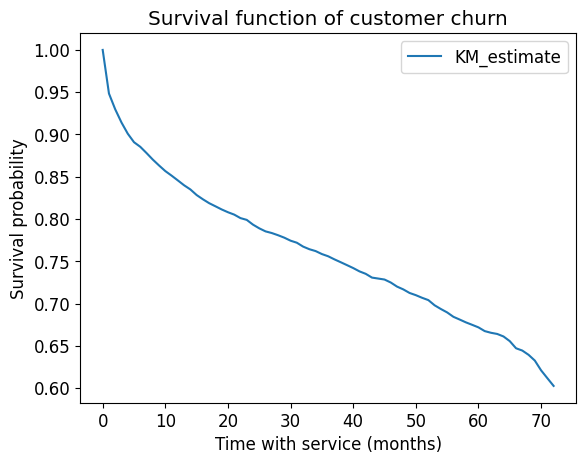

In [142]:
kmf.survival_function_.plot();
plt.title("Survival function of customer churn")
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- What is this plot telling us?
- It shows the probability of survival over time.
- For example, after 20 months the probability of survival is ~0.8. 
- Over time it's going down. 

What's the average tenure?

In [143]:
np.mean(train_df_surv["tenure"])

32.6391518364256

What's the average tenure of the people who churned?

In [144]:
np.mean(train_df_surv.query("Churn == 1.0")["tenure"])

17.854744525547446

What's the average tenure of the people who did not churn? 

In [145]:
np.mean(train_df_surv.query("Churn == 0.0")["tenure"])

37.816717791411044

- Let's look at the histogram of number of people who have not churned. 
- The key point here is that people _joined at different times_. 

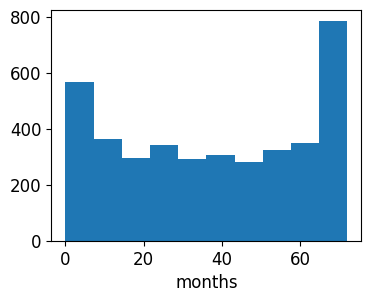

In [146]:
plt.figure(figsize=(4, 3))
train_df_surv[train_df_surv['Churn'] == 0]["tenure"].hist(grid=False)
plt.xlabel("months");

- Since the data was collected at a fixed time and these are the people who hadn't yet churned, those with larger `tenure` values here must have joined earlier.

Lifelines can also give us some "error bars":

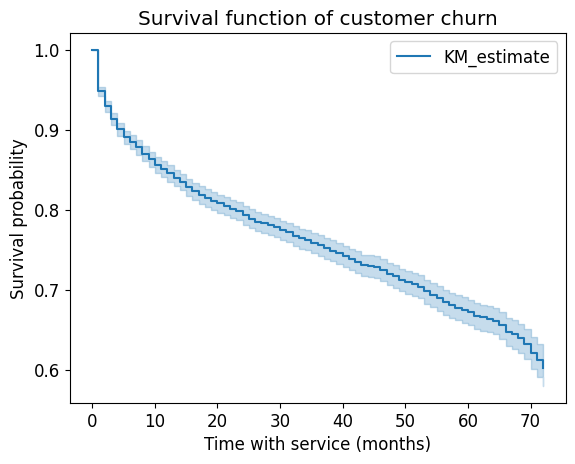

In [147]:
kmf.plot()
plt.title("Survival function of customer churn")
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- We already have some actionable information here.
- The curve drops down fast at the beginning suggesting that people tend to leave early on. 
- If there would have been a big drop in the curve, it means a bunch of people left at that time (e.g., after a 1-month free trial). 
- BTW, the [original paper by Kaplan and Meier](https://web.stanford.edu/~lutian/coursepdf/KMpaper.pdf) has been cited over 57000 times!

We can also create the K-M curve for different subgroups:

In [148]:
T = train_df_surv["tenure"]
E = train_df_surv["Churn"]
senior = train_df_surv["SeniorCitizen"] == 1

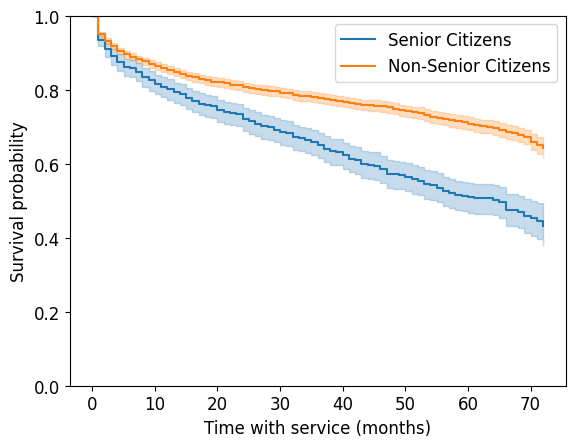

In [149]:
ax = plt.subplot(111)

kmf.fit(T[senior], event_observed=E[senior], label="Senior Citizens")
kmf.plot(ax=ax)

kmf.fit(T[~senior], event_observed=E[~senior], label="Non-Senior Citizens")
kmf.plot(ax=ax)

plt.ylim(0, 1)
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- It looks like senior citizens churn more quickly than others.
- This is quite useful!

<br><br>

## Cox proportional hazards model

- We haven't been incorporating other features in the model so far. 
- The Cox proportional hazards model is a commonly used model that allows us to interpret how features influence a censored tenure/duration. 
- You can think of it like linear regression for survival analysis: we will get a coefficient for each feature that tells us how it influences survival.
- It makes some strong assumptions (the proportional hazards assumption) that may not be true, but we won't go into this here.
- The proportional hazard model works multiplicatively, like linear regression with log-transformed targets.

In [150]:
cph = lifelines.CoxPHFitter()
# cph.fit(train_df_surv, duration_col="tenure", event_col="Churn");

- Ok, going to [this URL](https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model), it seems the easiest solution is to add a penalizer.
  - FYI this is related to switching from `LinearRegression` to `Ridge`.
  - Adding `drop='first'` on our OHE might have helped with this.
  - (For 340 folks: we're adding regularization; `lifelines` adds both L1 and L2 regularization, aka elastic net)

In [151]:
cph = lifelines.CoxPHFitter(penalizer=0.1)
cph.fit(train_df_surv, duration_col="tenure", event_col="Churn");

We can look at the coefficients learned by the model and start interpreting them! 

In [152]:
cph_params = pd.DataFrame(cph.params_).sort_values(by="coef", ascending=False)
cph_params

,coef
covariate,
Contract_Month-to-month,0.812875
OnlineSecurity_No,0.311151
OnlineBackup_No,0.298561
PaymentMethod_Electronic check,0.280801
Partner_No,0.244814
...,...
OnlineBackup_Yes,-0.282600
PaymentMethod_Credit card (automatic),-0.302801
OnlineSecurity_Yes,-0.330346


- Looks like month-to-month leads to more churn, two-year contract leads to less churn; this makes sense!!!

In [153]:
# cph.baseline_hazard_ # baseline hazard

In [154]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
SeniorCitizen,-0.019556,0.980634,0.057254,-0.131773,0.092660,0.876540,1.097088,0.0,-0.341571,0.732674,0.448757
MonthlyCharges,-0.003185,0.996820,0.040129,-0.081837,0.075467,0.921422,1.078387,0.0,-0.079377,0.936733,0.094290
OnlineSecurity_No,0.311151,1.364995,0.069644,0.174652,0.447650,1.190832,1.564631,0.0,4.467755,0.000008,16.948901
OnlineSecurity_No internet service,-0.057267,0.944342,0.100970,-0.255165,0.140631,0.774789,1.150999,0.0,-0.567169,0.570599,0.809450
OnlineSecurity_Yes,-0.330346,0.718675,0.072881,-0.473189,-0.187502,0.623012,0.829027,0.0,-4.532694,0.000006,17.389655
...,...,...,...,...,...,...,...,...,...,...,...
PaymentMethod_Electronic check,0.280801,1.324190,0.062293,0.158709,0.402892,1.171997,1.496146,0.0,4.507754,0.000007,17.219686
PaymentMethod_Mailed check,0.172697,1.188506,0.071787,0.031997,0.313397,1.032514,1.368064,0.0,2.405681,0.016142,5.953005
OnlineBackup_No,0.298561,1.347917,0.067781,0.165713,0.431408,1.180234,1.539424,0.0,4.404809,0.000011,16.527251


Could we have gotten this type of information out of sklearn?
- Yes, but the above approach is more appropriate for such problems. 

In [155]:
y_train.head()

6464     No
5707     No
3442     No
3932    Yes
6124     No
Name: Churn, dtype: object

In [156]:
X_train.drop(columns=["tenure"]).head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6464,4726-DLWQN,Male,1,No,No,Yes,Yes,DSL,Yes,Yes,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),70.35,3454.60
5707,4537-DKTAL,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45.55,84.40
3442,0468-YRPXN,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),98.80,2807.10
3932,1304-NECVQ,Female,1,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55
6124,7153-CHRBV,Female,0,Yes,Yes,Yes,No,DSL,Yes,No,Yes,Yes,No,No,One year,Yes,Mailed check,59.30,3274.35


I'm redefining feature types and our preprocessor for our sanity. 

In [157]:
numeric_features = ["MonthlyCharges"]
drop_features = ["customerID", "tenure", "TotalCharges"]
passthrough_features = ["SeniorCitizen"]
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [158]:
preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features,
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

In [159]:
preprocessor.fit(X_train);

In [160]:
new_columns = (
    numeric_features
    + preprocessor.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + passthrough_features
)

In [161]:
lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
lr.fit(X_train, y_train)
lr_coefs = pd.DataFrame(
    data=np.squeeze(lr[1].coef_), index=new_columns, columns=["Coefficient"]
)

In [162]:
lr_coefs.sort_values(by="Coefficient", ascending=False)

,Coefficient
Contract_Month-to-month,1.117063
InternetService_Fiber optic,0.522513
OnlineSecurity_No,0.349206
PaymentMethod_Electronic check,0.311261
OnlineBackup_No,0.253954
...,...
MonthlyCharges,-0.172977
OnlineSecurity_Yes,-0.242936
PaymentMethod_Credit card (automatic),-0.260652
InternetService_DSL,-0.416242


- There is some agreement, which is good.
- But our survival model is much more useful.
  - Not to mention more correct.

- One thing we get with `lifelines` is confidence intervals on the coefficients:

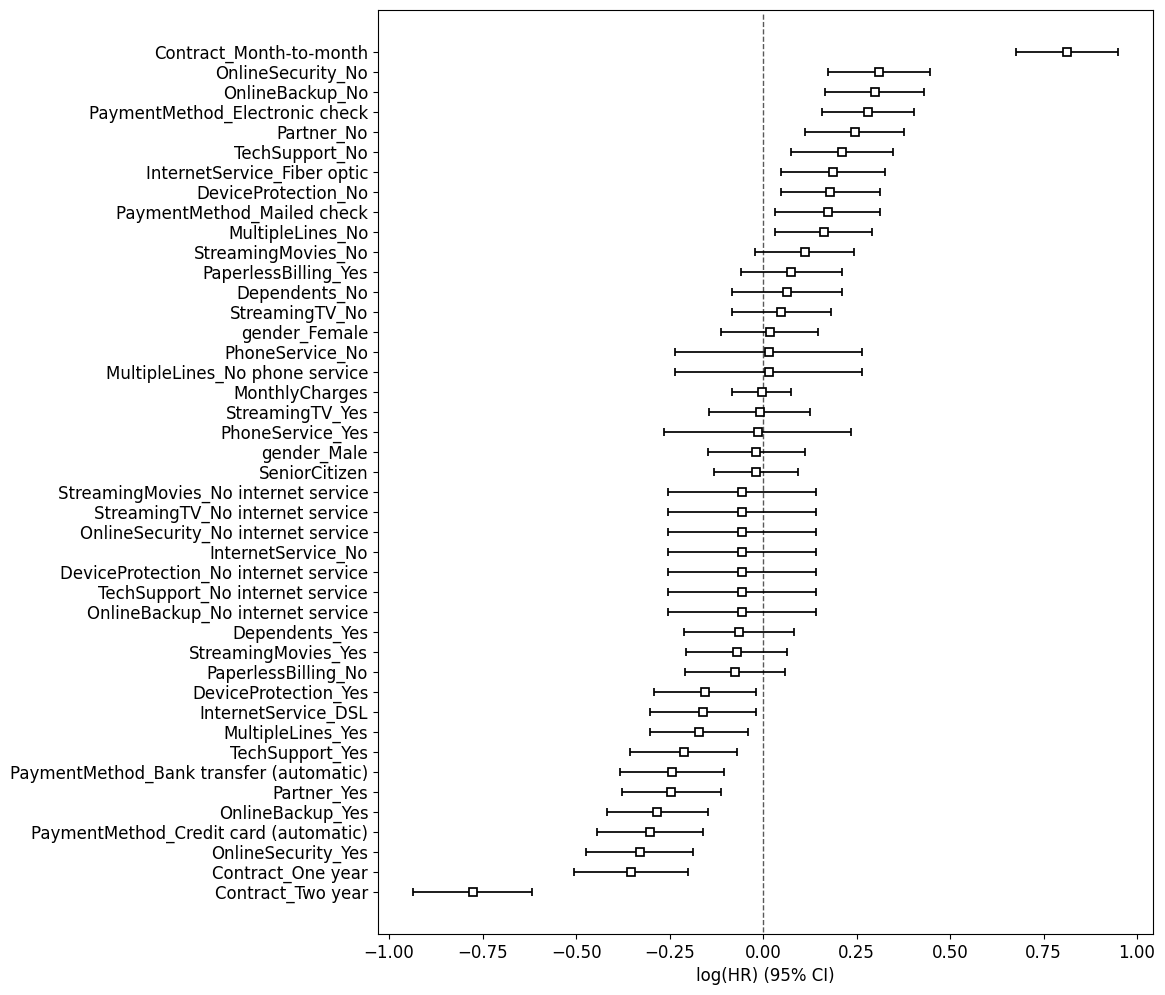

In [163]:
plt.figure(figsize=(10, 12))
cph.plot();

- (We could probably get the same for logistic regression if using `statsmodels` instead of sklearn.)
- However, in general, I would be careful with all of this.
- Ideally we would have more statistical training when using `lifelines` - there is a lot that can go wrong.
  - It comes with various diagnostics as well.
- But I think it's very useful to know about survival analysis and the availability of software to deal with it.
- Oh, and there are lots of other nice plots.

- Let's look at the survival plots for the people with 
    - two-year contract (Contract_Two year = 1) and 
    - people without two-year contract (Contract_Two year = 0)
- As expected, the former survive longer. 

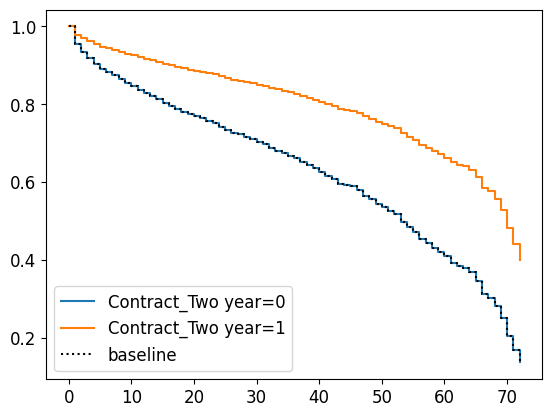

In [164]:
cph.plot_partial_effects_on_outcome("Contract_Two year", [0, 1]);

Now let's look at the survival plots for the people with different MonthlyCharges. 

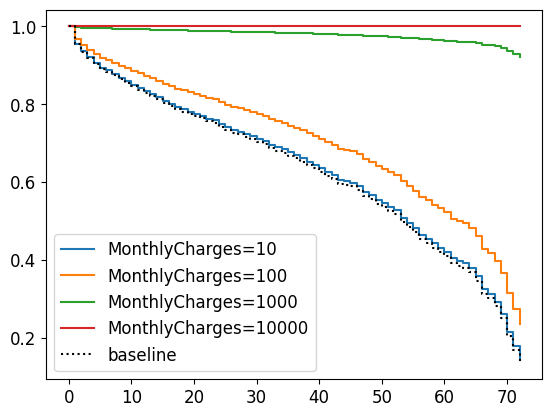

In [165]:
cph.plot_partial_effects_on_outcome("MonthlyCharges", [10, 100, 1000, 10_000]);

- That's the thing with linear models, they can't stop the growth.
- We have a negative coefficient associated with `MonthlyCharges`

In [166]:
cph_params.loc["MonthlyCharges"]

coef   -0.003185
Name: MonthlyCharges, dtype: float64

If your monthly charges are huge, it takes this to the extreme and thinks you'll basically never churn.

<br><br><br><br>

## Prediction

- We can use survival analysis to make predictions as well.
- Here is the expected number of months to churn for the first 5 customers in the test set:

In [167]:
test_df_surv.drop(columns=["tenure", "Churn"]).head()

,SeniorCitizen,MonthlyCharges,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,Partner_No,Partner_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,...,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes
941,0.0,-1.154900,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1404,0.0,-1.383246,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5515,0.0,-1.514920,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3684,0.0,0.351852,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7017,0.0,-1.471584,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [168]:
test_df_surv.head()

,Churn,tenure,SeniorCitizen,MonthlyCharges,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,Partner_No,Partner_Yes,MultipleLines_No,...,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes
941,0.0,13.0,0.0,-1.154900,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1404,0.0,35.0,0.0,-1.383246,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5515,0.0,18.0,0.0,-1.514920,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3684,0.0,43.0,0.0,0.351852,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7017,0.0,51.0,0.0,-1.471584,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


How long each non-churned customer is likely to stay according to the model assuming that they just joined right now?  

In [169]:
cph.predict_expectation(test_df_surv).head()  # assumes they just joined right now

941     35.206724
1404    69.023086
5515    68.608565
3684    27.565062
7017    67.890933
dtype: float64

Survival curves for first 5 customers in the test set:

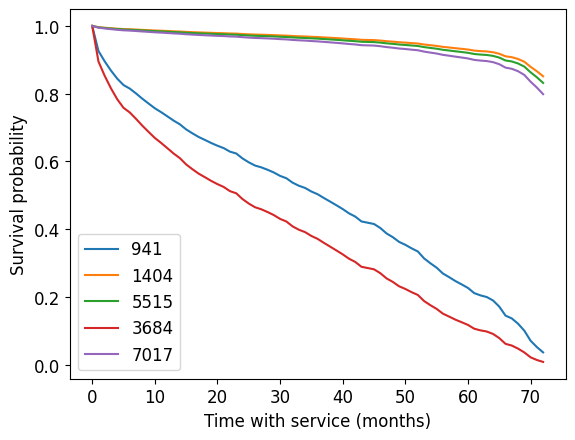

In [170]:
cph.predict_survival_function(test_df_surv[:5]).plot()
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

From `predict_survival_function` documentation:

> Predict the survival function for individuals, given their covariates. This assumes that the individual just entered the study (that is, we do not condition on how long they have already lived for.) 

So these curves are "starting now".

- There's no probability prerequisite for this course, so this is optional material.
- But you can do some interesting stuff here with conditional probabilities.
- "Given that a customer has been here 5 months, what's the outlook?"
  - It will be different than for a new customer. 
  - Thus, we might still want to predict for the non-churned customers in the training set!
  - Not something we really thought about with our traditional supervised learning.

Let's get the customers who have not churned yet.  

In [171]:
train_df_surv_not_churned = train_df_surv[train_df_surv["Churn"] == 0]

We can _condition_ on the person having been around for 20 months.

In [172]:
cph.predict_survival_function(train_df_surv_not_churned[:1], conditional_after=20)

,6464
0.0,1.000000
1.0,0.996788
2.0,0.991966
3.0,0.989443
4.0,0.982570
...,...
68.0,0.429634
69.0,0.429634
70.0,0.429634
71.0,0.429634


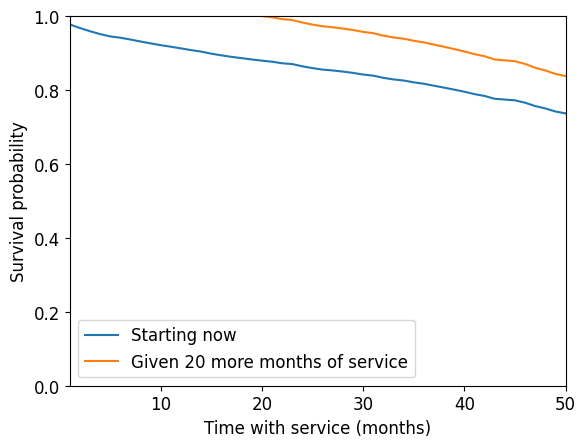

In [173]:
plt.figure()
cph.predict_survival_function(train_df_surv_not_churned[:1]).plot(ax=plt.gca())
preds = cph.predict_survival_function(
    train_df_surv_not_churned[:1], conditional_after=20
)
plt.plot(preds.index[20:], preds.values[:-20])
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability")
plt.legend(["Starting now", "Given 20 more months of service"])
plt.ylim([0, 1])
plt.xlim([1, 50]);

- Look at how the survival function (and expected lifetime) is much longer _given_ that the customer has already lasted 20 months.

- How long each non-churned customer is likely to stay according to the model assuming that they have been here for the tenure time? 
- So, we can set this to their actual tenure so far to get a prediciton of what will happen going forward:

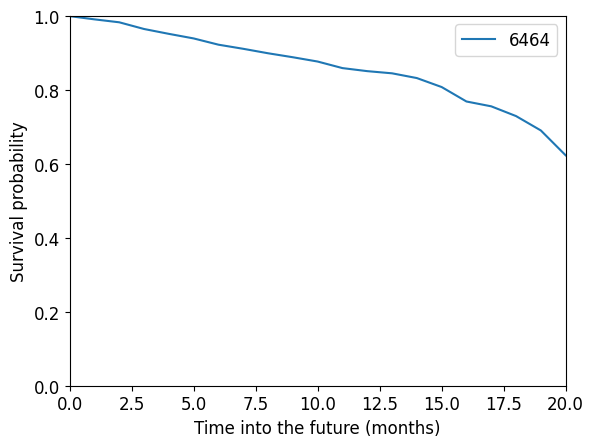

In [174]:
cph.predict_survival_function(
    train_df_surv_not_churned[:1],
    conditional_after=train_df_surv_not_churned[:1]["tenure"],
).plot()
plt.xlabel("Time into the future (months)")
plt.ylabel("Survival probability")
plt.ylim([0, 1])
plt.xlim([0, 20]);

- Another useful application: you could ask what is the [customer lifetime value](https://en.wikipedia.org/wiki/Customer_lifetime_value).
  - Basically, how much money do you expect to make off this customer between now and when they churn?
- With regular supervised learning, tenure was a feature and we could only predict whether or not they had churned by then.

<br><br>

## Evaluation 

By default score returns "partial log likelihood":

In [175]:
cph.score(train_df_surv)

-1.8641864337292489

In [176]:
cph.score(test_df_surv)

-1.7277854625841886

We can look at the "concordance index" which is more interpretable:

In [177]:
cph.concordance_index_

0.8625888648969532

In [178]:
cph.score(train_df_surv, scoring_method="concordance_index")

0.8625888648969532

In [179]:
cph.score(test_df_surv, scoring_method="concordance_index")

0.8546143543902771

From the documentation [here](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-and-calibration-in-survival-regression):

> Another censoring-sensitive measure is the concordance-index, also known as the c-index. This measure evaluates the accuracy of the ranking of predicted time. It is in fact a generalization of AUC, another common loss function, and is interpreted similarly:
> 
> - 0.5 is the expected result from random predictions,
> - 1.0 is perfect concordance and,
> - 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)
> 
> [Here](https://stats.stackexchange.com/a/478305/11867) is an excellent introduction & description of the c-index for new users.


In [180]:
# cph.log_likelihood_ratio_test()

In [181]:
# cph.check_assumptions(df_train_surv)

<br><br><br><br>

## Other approaches / what did we not cover? (5 min)

There are many other approaches to modelling in survival analysis:

- Time-varying proportional hazards.
  - What if some of the features change over time, e.g. plan type, number of lines, etc.
- Approaches based on deep learning, e.g. the [pysurvival](https://square.github.io/pysurvival/) package.
- Random survival forests.
- And more...

### Types of censoring
There are also various types and sub-types of censoring we didn't cover:

- What we did today is called "right censoring"
- Sub-types within right censoring
  - Did everyone join at the same time?
  - Other reasons the data might be censored at random times, e.g. the person died?
- Left censoring
- Interval censoring

## Summary

- Censoring and incorrect approaches to handling it
  - Throw away people who haven't churned
  - Assume everyone churns today
- Predicting tenure vs. churned
- Survival analysis encompasses both of these, and deals with censoring
- And it can make rich and interesting predictions!
- KM model -> doesn't look at features
- CPH model -> like linear regression, does look at the features

## References

Some people working with this same dataset:

- https://medium.com/@zachary.james.angell/applying-survival-analysis-to-customer-churn-40b5a809b05a
- https://towardsdatascience.com/churn-prediction-and-prevention-in-python-2d454e5fd9a5 (Cox)
- https://towardsdatascience.com/survival-analysis-in-python-a-model-for-customer-churn-e737c5242822
- https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e

lifelines documentation: 
- https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html
- https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#introduction-to-survival-analysis